In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from pprint import pprint
from typing import Any

import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
from numpy.typing import NDArray

from bioimageio.spec.model.v0_5 import (
    Author,
    AxisId,
    BatchAxis,
    ChannelAxis,
    CiteEntry,
    DatasetId,
    Doi,
    FileDescr,
    HttpUrl,
    Identifier,
    InputTensorDescr,
    IntervalOrRatioDataDescr,
    LicenseId,
    LinkedDataset,
    ModelDescr,
    OrcidId,
    ParameterizedSize,
    PytorchStateDictWeightsDescr,
    ScaleRangeDescr,
    ScaleRangeKwargs,
    SpaceInputAxis,
    TensorId,
    TorchscriptWeightsDescr,
    WeightsDescr,
)
from bioimageio.spec.pretty_validation_errors import (
    enable_pretty_validation_errors_in_ipynb,
)

In [3]:
enable_pretty_validation_errors_in_ipynb()
CMAP = "Greys"

def show(*paths: Path, d: int = 2):
    fig, axes = plt.subplots(1, len(paths), squeeze=False)
    for path, ax in zip(paths, axes.flatten()):
        ax.set_title(path.name)
        if path.suffix == ".npy":
            img: NDArray[Any] = np.load(path)
        else:
            img = imageio.v2.imread(path)

        img = img.squeeze()

        if img.ndim > 3 or img.ndim == 3 and min(img.shape) > 4:
            show3d(ax, img, d=d)
        else:
            show2d(ax, img)

    plt.show()

def show2d(ax, img: NDArray[Any]):
    ax.imshow(img, cmap=CMAP, vmin=0, vmax=1)
    ax.set_axis_off()


def show3d(ax, img: NDArray[Any], d: int):
    z, y, x = img.shape
    img -= np.percentile(img, 20)
    img = img / np.percentile(img, 99.99)

    img_show = np.ones((y+d+z, x+d+z), dtype=img.dtype)
    for a in (0, 2, 1):
        img_part = img.squeeze().max(axis=a)
        if a == 0:
            assert img_part.shape == (y, x), img_part.shape
            img_show[:y, :x] = img_part
        elif a== 1:
            assert img_part.shape == (z, x), img_part.shape
            img_show[y+d:, :x] = img_part
        elif a == 2:
            img_part = img_part.T
            assert img_part.shape == (y, z), img_part.shape
            img_show[:y, x+d:] = img_part
        else:
            raise NotImplementedError

    img_show[y+d:, x+d:] = 0
    # print(img_show.min(), img_show.max())
    ax.imshow(img_show, cmap=CMAP, vmin=0, vmax=1)
    ax.set_axis_off()

### Description details
<a id='details'></a>

In [4]:
root = Path().home() /"Desktop/demo"
!ls {root}

README.md
__pycache__
cover.png
model.py
model_teaser.py
rdf.yaml
sample_input.tif
sample_output.tif
test_input.npy
test_output.npy
weights.pt
weights_torchscript.pt


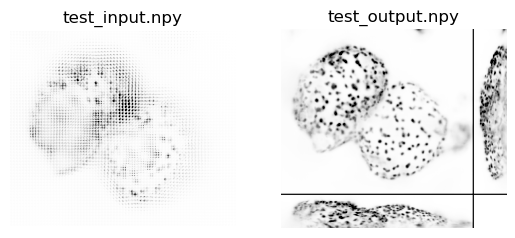

In [5]:
show(root / "test_input.npy", root / "test_output.npy")

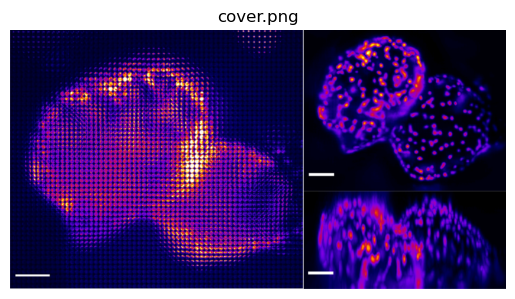

In [6]:
show(root / "cover.png")

#### Source Code of the model architecture

In [7]:
from IPython.display import Code

Code(filename=root / "model_teaser.py", language='python')

import torch.nn as nn


class HyLFM_Net(nn.Module):
    def __init__(
        self,
        *,
        z_out: int,
        nnum: int,
        kernel2d: int = 3,
        conv_per_block2d: int = 2,
        ...
    ):
        ...

    def forward(self, x):
        x = self.channel_from_lf(x)
        x = self.res2d(x)
        x = self.conv2d(x)
        x = self.c2z(x)
        x = self.res3d(x)
        x = self.conv3d(x)
        ...
        return x

#### Model Weights

In [8]:
pytorch_weights = torch.load(root / "weights.pt", weights_only=False)
pprint([(k, tuple(v.shape)) for k, v in pytorch_weights.items()][:4] + ["..."])

[('res2d.0.block.0.conv.weight', (768, 361, 3, 3)),
 ('res2d.0.block.0.conv.bias', (768,)),
 ('res2d.0.block.1.conv.weight', (768, 768, 3, 3)),
 ('res2d.0.block.1.conv.bias', (768,)),
 '...']


### Model Input

In [ ]:
input_descr = InputTensorDescr(
    id=TensorId("lf"),
    axes=[BatchAxis(),
          ChannelAxis(channel_names=[Identifier("lf")]),
          SpaceInputAxis(
              id=AxisId('y'),
              size=ParameterizedSize(min=190, step=19),
              scale=4,
              concatenable=False),
          SpaceInputAxis(
              id=AxisId('x'),
              size=ParameterizedSize(min=190, step=19),
              scale=4,
              concatenable=False),
    ],
    test_tensor=FileDescr(source=root / "test_input.npy"),
    sample_tensor=FileDescr(source=root / "sample_input.tif"),
    data=IntervalOrRatioDataDescr(type="float32"),
    preprocessing = [ScaleRangeDescr(
            kwargs=ScaleRangeKwargs(
                axes= (AxisId('y'), AxisId('x')),
                max_percentile= 99.8,
                min_percentile= 5.0,
            )
        )]
)

### Model Output

In [ ]:
from bioimageio.spec.model.v0_5 import OutputTensorDescr, SizeReference, SpaceOutputAxis

output_descr = OutputTensorDescr(
    id=TensorId("prediction"),
    description="predicted volume of fluorescence signal",
    axes=[BatchAxis(),
          ChannelAxis(channel_names=[Identifier("prediction")]),
          SpaceOutputAxis(id=AxisId("z"), size=49),
          SpaceOutputAxis(id=AxisId('y'),
                          scale=19,
                          size=SizeReference(tensor_id=TensorId("lf"),
                          axis_id=AxisId("y"),
                          offset=-16)),
          SpaceOutputAxis(id=AxisId('x'),
                          scale=19,
                          size=SizeReference(tensor_id=TensorId("lf"),
                          axis_id=AxisId("x"),
                          offset=-16)),
    ],
    test_tensor=FileDescr(source=root / "test_output.npy"),
    sample_tensor=FileDescr(source=root / "sample_output.tif"),
    data=IntervalOrRatioDataDescr(type="float32"),
)

### Model Architecture

In [ ]:
from bioimageio.spec.model.v0_5 import (
    ArchitectureFromFileDescr,
    Version,
)

pytorch_version = Version(torch.__version__)

pytorch_architecture = ArchitectureFromFileDescr(
    source=root / "model.py",
    callable=Identifier("HyLFM_Net"),
    kwargs=dict(
        c_in_3d=64,
        last_kernel2d=5,
        nnum=19,
        z_out=49,
    )
)

### Create a model description

In [ ]:
my_model_descr = ModelDescr(
  name="HyLFM-Net-stat",
  description=(
  "HyLFM-Net trained on static images of arrested medaka hatchling hearts. "
  + "The network reconstructs a volumentric image from a given light-field."
  ),
  covers=[root / "cover.png"],
  authors=[
      Author(
          name="Fynn Beuttenmueller",
          affiliation="EMBL Heidelberg",
          github_user="fynnbe",
          orcid=OrcidId("0000-0002-8567-6389"))
  ],
  cite=[
    CiteEntry(
      text=(
        "Beuttenmueller, Wagner, N., F., Norlin, N. et al."
      + " Deep learning-enhanced light-field imaging with continuous validation."
      + " Nat Methods 18, 557–563 (2021)."
      ),
      doi=Doi("10.1038/s41592-021-01136-0"),
    )
  ],
  license=LicenseId("MIT"),
  ...

In [ ]:
  ...
  documentation=root / "README.md",
  git_repo=HttpUrl("https://github.com/kreshuklab/hylfm-net"),
  tags= [
      "light-field-microscopy",
      "pytorch",
      "fluorescence-light-microscopy",
      "image-reconstruction",
      "nuclei",
      "hylfm",
  ],
  training_data=LinkedDataset(id=DatasetId("uplifting-ice-cream")),
  inputs=[input_descr],
  outputs=[output_descr],
  weights=WeightsDescr(
      pytorch_state_dict=PytorchStateDictWeightsDescr(
          source=root / "weights.pt",
          architecture=pytorch_architecture,
          pytorch_version=pytorch_version,
      ),
      torchscript=TorchscriptWeightsDescr(
          source=root / "weights_torchscript.pt",
          pytorch_version=pytorch_version,
          parent="pytorch_state_dict", # these weights were converted from the pytorch_state_dict weights ones.
      ),
  ),
  attachments=[FileDescr(source=root / "model_teaser.py")],
)

### Test a described model

In [ ]:
from bioimageio.core import test_model

validation_summary = test_model(my_model_descr)

In [14]:
validation_summary.display()


|        ✔️       | bioimageio validation passed |
|       ---       |             ---              |
| source          | in-memory                    |
| format version  | model 0.5.3                  |
| bioimageio.spec | 0.5.3.3                      |
| bioimageio.core | 0.6.10                       |

|  ❓  | location |                                         detail                                         |
| --- |   ---    |                                          ---                                           |
| ✔️  |          | initialized ModelDescr to describe model 0.5.3                                         |
| ✔️  |          | Has expected resource type                                                             |
| ✔️  |          | Reproduce test outputs from test inputs (pytorch_state_dict)                           |
| ✔️  |          | Run pytorch_state_dict inference for inputs with batch_size: 1 and size parameter n: 0 |
| ✔️  |          | Run pytorch_state_dict inference for inputs with batch_size: 2 and size parameter n: 0 |
| ✔️  |          | Run pytorch_state_dict inference for inputs with batch_size: 1 and size parameter n: 1 |
| ✔️  |          | Run pytorch_state_dict inference for inputs with batch_size: 2 and size parameter n: 1 |
| ✔️  |          | Run pytorch_state_dict inference for inputs with batch_size: 1 and size parameter n: 2 |
| ✔️  |          | Run pytorch_state_dict inference for inputs with batch_size: 2 and size parameter n: 2 |
| ✔️  |          | Reproduce test outputs from test inputs (torchscript)                                  |
| ✔️  |          | Run torchscript inference for inputs with batch_size: 1 and size parameter n: 0        |
| ✔️  |          | Run torchscript inference for inputs with batch_size: 2 and size parameter n: 0        |
| ✔️  |          | Run torchscript inference for inputs with batch_size: 1 and size parameter n: 1        |
| ✔️  |          | Run torchscript inference for inputs with batch_size: 2 and size parameter n: 1        |
| ✔️  |          | Run torchscript inference for inputs with batch_size: 1 and size parameter n: 2        |
| ✔️  |          | Run torchscript inference for inputs with batch_size: 2 and size parameter n: 2        |
